In [1]:
#Import libraries
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#use a fixed seed to ensure the same results
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
#Load processed dataset
df = pd.read_csv("../data/processed/clean_dataset_full.csv")
df.head()


,clean_symptoms,Age,Gender,Symptom_Count,label
0,fever back pain short breath,29,Male,3,0
1,insomnia back pain weight loss,76,Female,3,27
2,sore throat vomit diarrhea,78,Male,3,19
3,blur vision depress weight loss muscl pain,58,Other,4,26
4,swell appetit loss nausea,55,Female,3,16


In [4]:
#Encode gender as a numerical feature
df['Gender_encoded'] = df['Gender'].map({'Male':0, 'Female':1, 'Other':2})
df[['Gender', 'Gender_encoded']].head()


,Gender,Gender_encoded
0,Male,0
1,Female,1
2,Male,0
3,Other,2
4,Female,1


In [5]:
#Defining the target variable
y = df['label'].values

In [6]:
# Train / Test split (no validation needed for TF-IDF)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_symptoms'],
    y,
    test_size=0.15,
    random_state=SEED,
    stratify=y
)

In [7]:
# TF-IDF Vectorization of Symptom Text
tfidf = TfidfVectorizer(
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

In [8]:
# Combine Text and Numeric Features
X_numeric = df[['Age', 'Symptom_Count', 'Gender_encoded']].values

scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Split numeric features using the same indices
X_train_numeric = X_numeric_scaled[df.index.isin(X_train_text.index)]
X_test_numeric = X_numeric_scaled[df.index.isin(X_test_text.index)]

X_train = sparse.hstack([
    X_train_tfidf,
    sparse.csr_matrix(X_train_numeric)
])

X_test = sparse.hstack([
    X_test_tfidf,
    sparse.csr_matrix(X_test_numeric)
])


In [9]:
#Train Logistic Regression Model
clf = LogisticRegression(
    max_iter=4000,
    solver='saga',
    class_weight='balanced',
     random_state=SEED,
)

clf.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [10]:
#Evaluation Metrics
y_pred = clf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))


Test Accuracy: 0.036

 Classification Report:

              precision    recall  f1-score   support

           0       0.06      0.05      0.06       129
           1       0.04      0.04      0.04       122
           2       0.02      0.01      0.02       137
           3       0.03      0.03      0.03       134
           4       0.02      0.03      0.02       117
           5       0.08      0.07      0.07       128
           6       0.02      0.02      0.02       126
           7       0.03      0.03      0.03       121
           8       0.02      0.02      0.02       121
           9       0.05      0.04      0.04       123
          10       0.04      0.04      0.04       129
          11       0.00      0.00      0.00       128
          12       0.01      0.01      0.01       127
          13       0.03      0.03      0.03       125
          14       0.02      0.02      0.02       131
          15       0.05      0.06      0.05       121
          16       0.05      0.06 

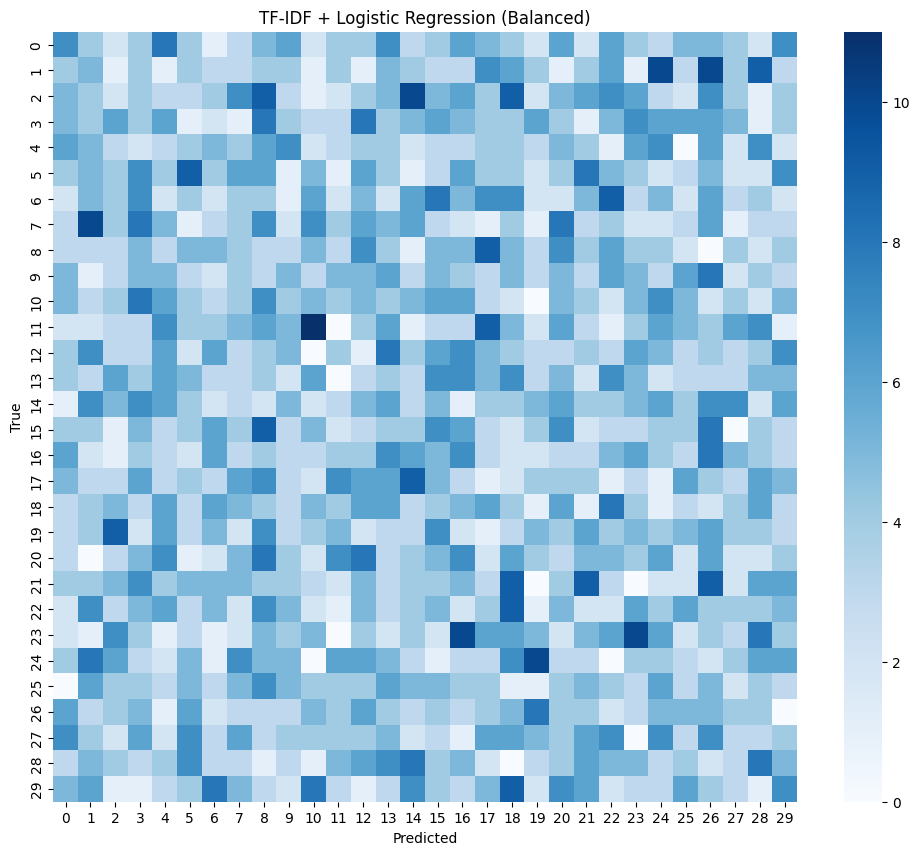

In [11]:
#Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("TF-IDF + Logistic Regression (Balanced)")
plt.show()


In [12]:
#Save Model and Vectorizer for Deployment
joblib.dump(clf, "../data/processed/tfidf_logreg_model.pkl")

joblib.dump(tfidf, "../data/processed/tfidf_vectorizer.pkl")


['../data/processed/tfidf_vectorizer.pkl']

In [13]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download("stopwords")

stop_words = set(stopwords.words("english"))
ps = PorterStemmer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [ps.stem(w) for w in words]
    return " ".join(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
#DATA INPUT FOR DEMO

demo_symptoms = "fever cough headache"
demo_age = 30
demo_symptom_count = 3
demo_gender = "Male"   # Male / Female / Other

In [15]:
#DEMO gender encoding
gender_map = {"Male": 0, "Female": 1, "Other": 2}
demo_gender_encoded = gender_map[demo_gender]

demo_numeric = np.array([[demo_age, demo_symptom_count, demo_gender_encoded]])
demo_numeric_scaled = scaler.transform(demo_numeric)

In [16]:
#DEMO TF-IDF Vectorization

demo_clean_symptoms = clean_text(demo_symptoms)
demo_tfidf = tfidf.transform([demo_clean_symptoms])

In [17]:
#DEMO Feature Combination

demo_input = sparse.hstack([
    demo_tfidf,
    sparse.csr_matrix(demo_numeric_scaled)
])

In [18]:
#DEMO Label index to Disease name mapping

df_raw = pd.read_csv("../data/Healthcare.csv")

label_map = dict(
    enumerate(df_raw["Disease"].astype("category").cat.categories)
)


In [19]:
#Predictions

pred_class = clf.predict(demo_input)[0]
pred_label = label_map[pred_class]

print("Input symptoms:", demo_symptoms)
print("Predicted disease:", pred_label)


Input symptoms: fever cough headache
Predicted disease: Heart Disease


In [20]:
#Top-5 Predictions

probs = clf.predict_proba(demo_input)[0]
top_k = 5

top_indices = np.argsort(probs)[-top_k:][::-1]
top_labels = [label_map[i] for i in top_indices]

print("\nTop predictions:")
for label, prob in zip(top_labels, probs[top_indices]):
    print(f"{label}: {prob:.4f}")



Top predictions:
Heart Disease: 0.1028
Migraine: 0.0751
Anxiety: 0.0619
Anemia: 0.0578
Chronic Kidney Disease: 0.0567
